# Backtesting ML Classification-Based

## Load the model

In [4]:
import pickle

In [5]:
with open('models/model_dt_classification.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [6]:
model_dt

DecisionTreeClassifier(max_depth=15)

## Load the data

In [7]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2016-12-08,55.181129,55.696675,55.027373,55.443424,21220800,1.549137,UP
2016-12-09,56.049412,56.067501,55.289665,55.334887,27349400,0.321693,UP
2016-12-12,56.230301,56.347882,55.823296,55.913741,20198100,1.286142,UP
2016-12-13,56.962925,57.360886,56.293626,56.528784,35718900,-0.478631,DOWN
2016-12-14,56.691582,57.388017,56.555911,56.981009,30352700,-0.159803,DOWN
...,...,...,...,...,...,...,...
2025-02-27,392.529999,405.739990,392.170013,401.269989,21127400,1.123452,UP
2025-02-28,396.989990,397.630005,386.570007,392.660004,32845700,-2.187959,DOWN
2025-03-03,388.489990,398.820007,386.160004,398.820007,23007700,0.030878,UP


## Backtesting.py Library

### Create your Strategy Class

In [9]:
!pip install backtesting
from backtesting import Backtest, Strategy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/codespace/.python/current/lib/python3.12/site-packages/backtesting/_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [10]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [11]:
df_explanatory.iloc[-1:, :]

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-05,389.339996,401.670013,388.809998,401.019989,23412000


In [12]:
df.change_tomorrow_direction[-1:]

Date
2025-03-05    DOWN
Name: change_tomorrow_direction, dtype: object

#### Simulate the prediction for the last observation

In [13]:
model_dt.predict(X=df_explanatory)

array(['UP', 'UP', 'UP', ..., 'UP', 'UP', 'UP'],
      shape=(2070,), dtype=object)

In [14]:
explanatory_today = df_explanatory.iloc[[-1],:]

In [15]:
forecast_tomorrow = model_dt.predict(explanatory_today)[0]

#### Write the prediction process in the Strategy class

In [16]:
class ClassificationUP(Strategy):
    def init(self):
        self.model = model_dt

    def next(self):
        explanatory_today = df_explanatory.iloc[[-1],:]
        forecast_tomorrow = model_dt.predict(explanatory_today)[0]
        
        # conditions to sell or buy

#### Calculate Purchase Recommendation

##### Buy if it goes up

In [17]:
list_buy = []

In [18]:
for direction_tomorrow in df.change_tomorrow_direction:
    if direction_tomorrow == 'UP':
        list_buy.append(1)
    else:
        list_buy.append(0)

In [19]:
df['buy'] = list_buy

In [20]:
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction,buy
Date,,,,,,,,
2016-12-08,55.181129,55.696675,55.027373,55.443424,21220800,1.549137,UP,1
2016-12-09,56.049412,56.067501,55.289665,55.334887,27349400,0.321693,UP,1
2016-12-12,56.230301,56.347882,55.823296,55.913741,20198100,1.286142,UP,1
2016-12-13,56.962925,57.360886,56.293626,56.528784,35718900,-0.478631,DOWN,0
2016-12-14,56.691582,57.388017,56.555911,56.981009,30352700,-0.159803,DOWN,0
...,...,...,...,...,...,...,...,...
2025-02-27,392.529999,405.739990,392.170013,401.269989,21127400,1.123452,UP,1
2025-02-28,396.989990,397.630005,386.570007,392.660004,32845700,-2.187959,DOWN,0
2025-03-03,388.489990,398.820007,386.160004,398.820007,23007700,0.030878,UP,1


##### Buy if it goes and sell if down

> You can only sell if you have already bought

In [21]:
list_buy_sell = []
already_bought = False

In [22]:
for direction_tomorrow in df.change_tomorrow_direction:
    if direction_tomorrow == 'UP' and already_bought == False:
        list_buy_sell.append(1)
        already_bought = True
    elif direction_tomorrow == 'DOWN' and already_bought == True:
        list_buy_sell.append(-1)
        already_bought = False
    else:
        list_buy_sell.append(0)

In [23]:
df['buy_sell'] = list_buy_sell

In [24]:
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction,buy,buy_sell
Date,,,,,,,,,
2016-12-08,55.181129,55.696675,55.027373,55.443424,21220800,1.549137,UP,1,1
2016-12-09,56.049412,56.067501,55.289665,55.334887,27349400,0.321693,UP,1,0
2016-12-12,56.230301,56.347882,55.823296,55.913741,20198100,1.286142,UP,1,0
2016-12-13,56.962925,57.360886,56.293626,56.528784,35718900,-0.478631,DOWN,0,-1
2016-12-14,56.691582,57.388017,56.555911,56.981009,30352700,-0.159803,DOWN,0,0
...,...,...,...,...,...,...,...,...,...
2025-02-27,392.529999,405.739990,392.170013,401.269989,21127400,1.123452,UP,1,1
2025-02-28,396.989990,397.630005,386.570007,392.660004,32845700,-2.187959,DOWN,0,-1
2025-03-03,388.489990,398.820007,386.160004,398.820007,23007700,0.030878,UP,1,1


#### Add conditions to the strategy

In [26]:
class SimpleClassificationUD(Strategy):
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        # conditions to sell or buy
        if forecast_tomorrow == 'UP' and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == 'DOWN' and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Define initial conditions

In [27]:
bt = Backtest(df_explanatory, SimpleClassificationUD,
              cash=10000, commission=.002, exclusive_orders=True)

### Run backtesting

In [28]:
results = bt.run()

### Interpret backtesting results

In [29]:
results.to_frame(name='Values').loc[:'Return [%]']

,Values
Start,2016-12-08 00:00:00
End,2025-03-05 00:00:00
Duration,3009 days 00:00:00
Exposure Time [%],99.855072
Equity Final [$],28596550.674255
Equity Peak [$],28596550.674255
Commissions [$],11979607.476961
Return [%],285865.506743


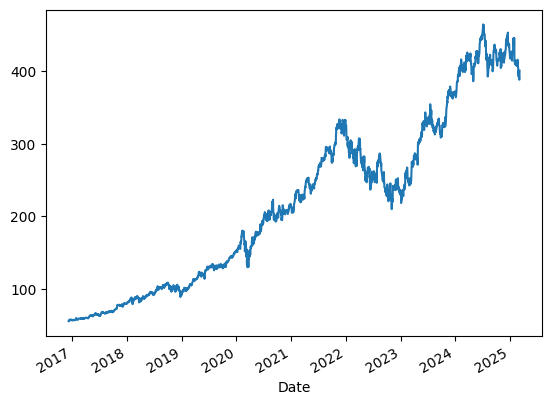

In [30]:
df.Close.plot();